# Segmenting the picture of greek coins in regions


- Spectral Clustering
    - spectral clustering은 graph-based 방법이다.
    - graph-based 클러스터링 모델은 각 데이터의 점들과 다른 점 사이에 선을 긋고 두 데이터의 유사도에 따라 가중치를 부여한다.
    - 두 데이터간의 유사점이 많으면 큰 가중치, 유사점이 낮으면 작은 가중치를 줘서 두 그룹으로 분류하도록 한다.
    - graph-based 클러스터링에서 두 그룹으로 나누는 방식으로는 minimum cut과 normalized cut 방법이 존재한다.

- 이 예에서는 이미지의 voxel-to-voxel(볼륨 요소) 차이에서 생성된 그래프에 Spectral clustering을 사용하여 이미지를 여러 부분적으로 균질한 영역으로 분할한다.
- 이미지에 대한 spectral clustering은 정규화 그래프 컷을 찾기 위한 효율적인 normalized 솔루션이다.
- 레이블을 할당하는 3가지 옵션이 있다.
    - `kmeans`: spectral clustering은 kmeans 알고리즘을 사용하여 임베딩 공간의 샘플을 클러스터링한다.
    - `discrete`: spectral clustering의 임베딩 공간에 가장 가까운 파티션 공간을 반복적으로 검색한다.
    - `cluster_qr`: 피벗팅이 있는 QR 분해를 사용하여 레이블을 할당하여 임베딩 공간의 파티션을 직접 결정한다.

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.data import coins
from skimage.transform import rescale

from sklearn.cluster import spectral_clustering
from sklearn.feature_extraction import image

# 코인을 numpy 배열로 불러오기
orig_coins = coins()

# 처리 속도를 높이기 위해 원본 크기의 20%로 크기를 조정한다.
# 다운 스케일 전에 스무딩을 위한 가우시안 필터를 적용하면 앨리어싱 아티팩트를 줄일 수 있다.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(smoothened_coins, 0.2, mode='reflect', anti_aliasing=False)

# 그래프의 edge에 원본 이미지의 그래디언트 값이 저장되도록 이미지를 그래프로 변환한다.
graph = image.img_to_graph(rescaled_coins)

# 그래디언트의 감소 함수로 지수 함수 사용
# 베타 값이 작을수록 실제 이미지의 segmentation은 더 독립적이다.
# 베타가 1일 때, segmentation은 voronoi에 가깝다.
beta = 10
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# 보여줄 segmented 영역의 수는 수동으로 선택해야 한다.
# spectral clustering의 현재 버전은 좋은 품질의 클러스터 수를 자동으로 결정하는 기능을 지원하지 않는다.
n_regions = 26

결과 영역들을 계산하고 보여주기

Spectral clustering: kmeans, 1.45s
Spectral clustering: discretize, 1.33s
Spectral clustering: cluster_qr, 1.39s


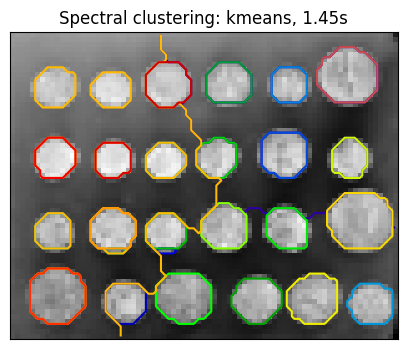

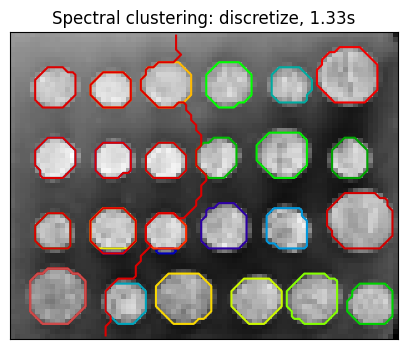

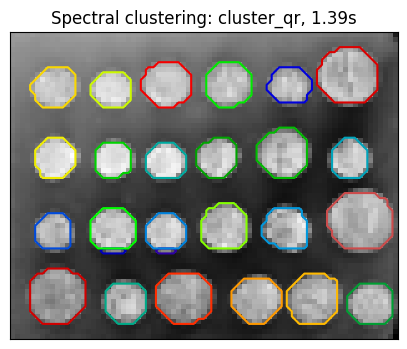

In [4]:
# 추가적인 고유 벡터를 계산하면 eigen_solver의 속도가 빨라질 수 있다.
# spectral clustering의 품질도 segmentation을 위해 추가적인 영역을 요청함으로 향상될 수 있다.
n_regions_plus = 3

# eigen_solver='arpack'을 사용하여 sperctral clustering을 적용한다.
# 어떤 solver든 사용할 수 있다.: eigen_solver='arpack', ;lobpcg', 'amg'
# eigen_solver='amg'는 pyamg라는 추가 패키지가 필요하다.
# segmentation 품지과 계산 속도는 주로 solver의 선택과 허용 오차 eigen_tol의 값에 의해 결정된다.
for assign_labels in ("kmeans", "discretize", "cluster_qr"):
    t0 = time.time()
    labels = spectral_clustering(
        graph,
        n_clusters=(n_regions + n_regions_plus),
        eigen_tol=1e-7,
        assign_labels=assign_labels,
        random_state=42,
    )

    t1 = time.time()
    labels = labels.reshape(rescaled_coins.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(rescaled_coins, cmap=plt.cm.gray)

    plt.xticks(())
    plt.yticks(())
    title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
    for l in range(n_regions):
        colors = [plt.cm.nipy_spectral((l + 4) / float(n_regions + 4))]
        plt.contour(labels == l, colors=colors)
plt.show()
